In [1]:
import os
import glob
import pathlib
import matplotlib_set_diagrams
import polars as pl
import numpy as np
import matplotlib.pylab as plt

from matplotlib.cbook import flatten
from matplotlib.axes import Axes
from matplotlib.patches import Patch
from typing import Any
from collections import OrderedDict, defaultdict

In [2]:
# If running with nbconvert 
WD = pathlib.Path(os.getcwd())
INTERACTIVE = WD.parts[-1] == "notebooks"
PATH_PREFIX = "../../" if INTERACTIVE else ""
OUTPUT_DIR = pathlib.Path(f"{PATH_PREFIX}results/nucflag_aligner_comparison").absolute()

CHROMS = [*[f"chr{i}" for i in range(1, 23)], "chrX", "chrY"]
ALIGNER_COLORS = ["#FF6666", "#66FF66", "#66B2FF"]
STATUS_COLORS = OrderedDict({
    "good": "blue",
    "misassembled": "orange"
})
ALIGNER_PARAMS = OrderedDict({
    "pbmm2": "pbmm2\n(-log-level DEBUG\n--preset SUBREAD\n--min-length 5000 -j 24)",
    "winnowmap": "winnowmap\n(-a --eqx --cs\n-x map-pb\n-t 24 -I8g)",
    "minimap2": "minimap2\n(-a --eqx --cs\n-x map-hifi\n-t 24 -I8g)"
})

In [3]:
OUTPUT_DIR.mkdir(exist_ok=True)

# Runtime Benchmarks

In [4]:
bmk_rows = []
for bmk in glob.glob(f"{PATH_PREFIX}benchmarks/nucflag_*/align_*"):
    path = pathlib.Path(bmk)
    run_type = path.parts[3] if INTERACTIVE else path.parts[1]

    with open(path, "rt") as fh:
        next(fh)
        for line in fh.readlines():
            wall_time, _, rss, *_, cpu_time = line.strip().split()
            bmk_rows.append((run_type, path.parts[-1], wall_time, cpu_time, rss))

df_bmk = (
    pl.DataFrame(
        bmk_rows,
        schema={
            "aligner": pl.String,
            "reads_file": pl.String,
            "wall_time": pl.Float32,
            "cpu_time": pl.Float32,
            "rss": pl.Float32
        }
    )
    .with_columns(
        pl.col("aligner").str.replace("nucflag_", "", literal=True).cast(pl.Enum(ALIGNER_PARAMS.keys())),
        pl.col("reads_file").str.extract(r"^align_(.*?)_hifi_reads_to_asm.tsv"),
        pl.col("cpu_time") / 3600,
        pl.col("wall_time") / 3600,
        pl.col("rss") / 1000
    )
)
df_bmk

aligner,reads_file,wall_time,cpu_time,rss
enum,str,f32,f32,f32
"""pbmm2""","""HG01884_HG01884.m54329U_210713…",1.251153,28.678995,90.396286
"""pbmm2""","""HG00609_m84081_231124_021221_s…",1.409482,32.875549,132.907135
"""pbmm2""","""HG01884_m84046_230707_192442_s…",0.418759,9.375425,105.31498
"""pbmm2""","""HG00423_m84081_231112_030942_s…",0.963935,19.23654,130.623184
"""pbmm2""","""HG00544_m84081_231119_032407_s…",1.344057,27.926069,130.272659
…,…,…,…,…
"""minimap2""","""HG01346_HG01346.m64076_210621_…",0.545695,11.189831,83.087303
"""minimap2""","""HG01099_m84081_231124_024327_s…",0.411005,7.472739,61.803291
"""minimap2""","""HG01884_HG01884.m54329U_210716…",0.531145,10.661254,80.56839


In [5]:
def draw_boxplots(df: pl.DataFrame, col: str, title: str, ylabel: str, *, sharey: bool = True, xlabels: dict[str, str] | None = None) -> tuple[plt.Figure, Any]:
    fig, axs = plt.subplots(1, 3, figsize=(8, 8), sharey=sharey)
    fig.suptitle(title)
    fig.supylabel(ylabel)
    fig.tight_layout()
    
    xlabels = xlabels if xlabels else {}

    for ax, (categ, df_categ), color in zip(axs, df.group_by(["aligner"], maintain_order=True), ALIGNER_COLORS):
        categ = categ[0]
        ax: Axes

        bplot = ax.boxplot(df_categ[col], manage_ticks=True, patch_artist=True)
        for patch in bplot["boxes"]:
            patch.set_facecolor(color)
        ax.set_xlabel(xlabels.get(categ, categ))
        ax.set_xticks([])

        quantiles = (df_categ[col].quantile(q) for q in [0.25, 0.5, 0.75])
        for q in quantiles:
            y = q
            ax.annotate(
                '%.2f' % q,
                (1, y),
                xytext=(1-0.1, y),
                textcoords='data',
                va='center',
                ha='right'
            )
    
    return fig, axs


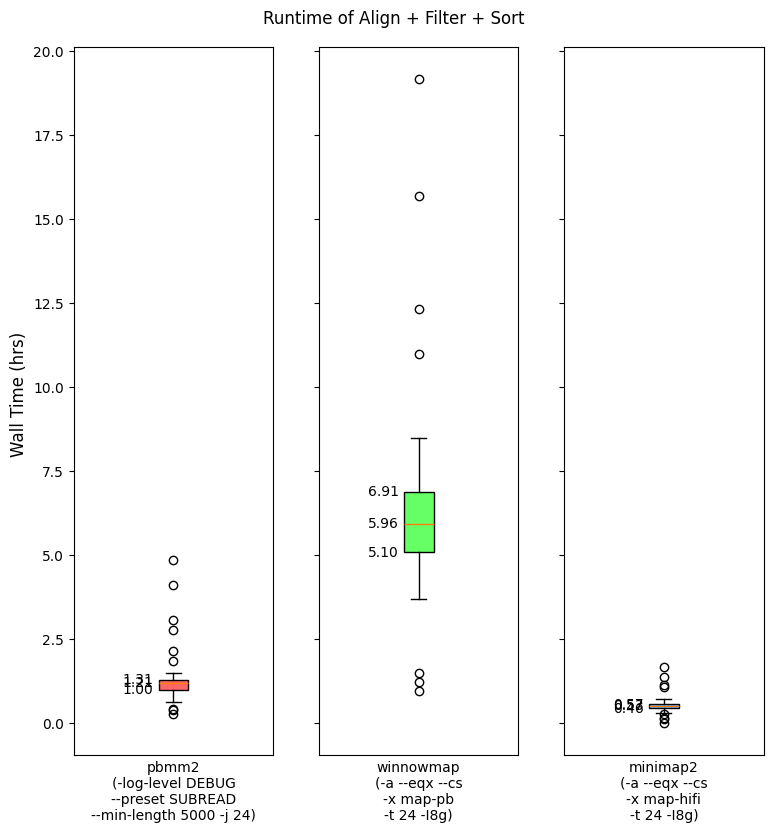

In [6]:
plt.close("all")
fig_wall_time, _ = draw_boxplots(df_bmk, "wall_time", "Runtime of Align + Filter + Sort", "Wall Time (hrs)", xlabels=ALIGNER_PARAMS)
fig_wall_time.savefig(OUTPUT_DIR.joinpath("wall_time.png"), bbox_inches="tight")
fig_wall_time.show()

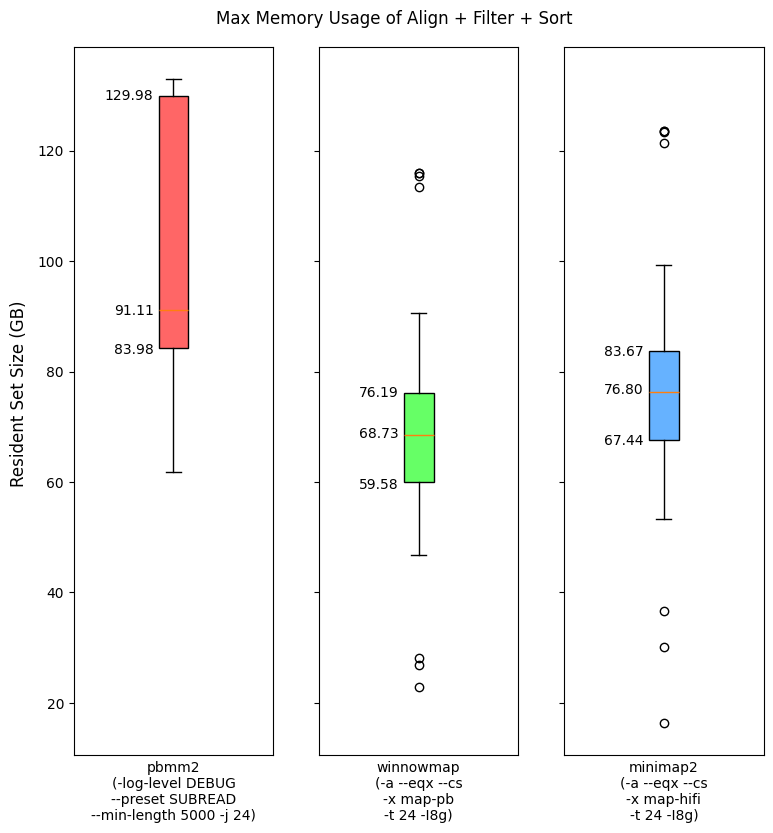

In [7]:
plt.close("all")
fig_memory, _ = draw_boxplots(df_bmk, "rss", "Max Memory Usage of Align + Filter + Sort", "Resident Set Size (GB)", xlabels=ALIGNER_PARAMS)
fig_memory.savefig(OUTPUT_DIR.joinpath("memory_usage.png"), bbox_inches="tight")
fig_memory.show()

# Number of Centromeres Correct

In [8]:
df_all_status_long = pl.concat(
    pl.read_csv(
        f"{PATH_PREFIX}results/nucflag_{aligner_name}/*_cen_status.bed",
        separator="\t",
        has_header=False,
        new_columns=["ctg", "start", "stop", "status"],
        glob=True
    )
    .with_columns(
        aligner=pl.lit(aligner_name),
        chrom=pl.col("ctg").str.extract(r"_(rc-)*(chr\w*?)_", group_index=2),
        sample=pl.col("ctg").str.extract(r"(\w*?)_"),
    )
    .with_columns(
        pl.col("aligner").cast(pl.Enum(ALIGNER_PARAMS.keys())),
        pl.col("chrom").cast(pl.Enum(CHROMS)),
        pl.col("status").cast(pl.Enum(STATUS_COLORS.keys()))
    )
    for aligner_name in ALIGNER_PARAMS.keys()
)
df_all_status_long

ctg,start,stop,status,aligner,chrom,sample
str,i64,i64,enum,enum,enum,str
"""HG00423_chr11_mat-0000008""",49909771,55596070,"""good""","""pbmm2""","""chr11""","""HG00423"""
"""HG00423_chr11_pat-0000497""",49558777,58059626,"""misassembled""","""pbmm2""","""chr11""","""HG00423"""
"""HG00423_chr12_mat-0000022""",33925857,37861752,"""misassembled""","""pbmm2""","""chr12""","""HG00423"""
"""HG00423_chr12_pat-0000510""",33907076,38497051,"""misassembled""","""pbmm2""","""chr12""","""HG00423"""
"""HG00423_chr16_mat-0000018""",34528119,37281696,"""good""","""pbmm2""","""chr16""","""HG00423"""
…,…,…,…,…,…,…
"""HG01884_rc-chr4_mat-0000012""",48980011,53893076,"""misassembled""","""minimap2""","""chr4""","""HG01884"""
"""HG01884_rc-chr4_pat-0000348""",49080813,53341862,"""misassembled""","""minimap2""","""chr4""","""HG01884"""
"""HG01884_rc-chr5_pat-0000363""",45847821,53002620,"""misassembled""","""minimap2""","""chr5""","""HG01884"""


In [9]:
df_all_status_wide = df_all_status_long.pivot(index=["ctg", "start", "stop", "chrom", "sample"], columns="aligner", values="status")
df_all_status_wide

ctg,start,stop,chrom,sample,pbmm2,winnowmap,minimap2
str,i64,i64,enum,str,enum,enum,enum
"""HG00423_chr11_mat-0000008""",49909771,55596070,"""chr11""","""HG00423""","""good""","""good""","""good"""
"""HG00423_chr11_pat-0000497""",49558777,58059626,"""chr11""","""HG00423""","""misassembled""","""misassembled""","""misassembled"""
"""HG00423_chr12_mat-0000022""",33925857,37861752,"""chr12""","""HG00423""","""misassembled""","""misassembled""","""good"""
"""HG00423_chr12_pat-0000510""",33907076,38497051,"""chr12""","""HG00423""","""misassembled""","""misassembled""","""misassembled"""
"""HG00423_chr16_mat-0000018""",34528119,37281696,"""chr16""","""HG00423""","""good""","""good""","""good"""
…,…,…,…,…,…,…,…
"""HG01884_rc-chr4_mat-0000012""",48980011,53893076,"""chr4""","""HG01884""","""misassembled""","""misassembled""","""misassembled"""
"""HG01884_rc-chr4_pat-0000348""",49080813,53341862,"""chr4""","""HG01884""","""misassembled""","""misassembled""","""misassembled"""
"""HG01884_rc-chr5_pat-0000363""",45847821,53002620,"""chr5""","""HG01884""","""misassembled""","""misassembled""","""misassembled"""


In [10]:
def venn_bitwise_not(aligner: str) -> pl.Expr:
    return (
        pl.when(pl.col(aligner) == "1")
        .then(pl.lit("0"))
        .when(pl.col(aligner) == "0")
        .then(pl.lit("1"))
        .otherwise(pl.col("pbmm2"))
    )
df_all_status_combined = (
    df_all_status_wide
    .select("chrom", "pbmm2", "winnowmap", "minimap2")
    .with_columns(pl.col("pbmm2", "winnowmap", "minimap2").cast(pl.String))
    .with_columns(pl.col("pbmm2", "winnowmap", "minimap2").replace({"good": 1, "misassembled": 0}))
    .select(
        pl.col("chrom"),
        pl.col("pbmm2"), pl.col("winnowmap"), pl.col("minimap2"),
        comb=pl.col("pbmm2") + pl.col("winnowmap") + pl.col("minimap2"),
        comb_neg=(
            venn_bitwise_not("pbmm2") + venn_bitwise_not("winnowmap") + venn_bitwise_not("minimap2")
        )
    )
)
df_all_status_combined

chrom,pbmm2,winnowmap,minimap2,comb,comb_neg
enum,str,str,str,str,str
"""chr11""","""1""","""1""","""1""","""111""","""000"""
"""chr11""","""0""","""0""","""0""","""000""","""111"""
"""chr12""","""0""","""0""","""1""","""001""","""110"""
"""chr12""","""0""","""0""","""0""","""000""","""111"""
"""chr16""","""1""","""1""","""1""","""111""","""000"""
…,…,…,…,…,…
"""chr4""","""0""","""0""","""0""","""000""","""111"""
"""chr4""","""0""","""0""","""0""","""000""","""111"""
"""chr5""","""0""","""0""","""0""","""000""","""111"""


In [11]:
df_all_status_grouped_combined = df_all_status_combined.group_by("chrom").agg(pl.col("comb").value_counts()).sort(by="chrom")
df_all_status_grouped_combined

chrom,comb
enum,list[struct[2]]
"""chr1""","[{""000"",16}, {""101"",2}, {""111"",2}]"
"""chr2""","[{""111"",9}, {""101"",2}, {""000"",9}]"
"""chr3""","[{""111"",6}, {""101"",1}, … {""110"",2}]"
"""chr4""","[{""111"",9}, {""000"",10}]"
"""chr5""","[{""110"",1}, {""000"",17}, {""111"",2}]"
…,…
"""chr20""","[{""100"",1}, {""000"",14}, … {""111"",3}]"
"""chr21""","[{""000"",6}, {""111"",13}]"
"""chr22""","[{""111"",7}, {""101"",3}, … {""000"",11}]"


/home/koisland/miniforge3/envs/jupyter/lib/python3.12/site-packages/matplotlib_set_diagrams/_diagram_classes.py:438: UserWarning: Iteration limit reached. Could not optimise layout for the given subsets. Try a different cost function objective.
  warnings.warn(f"{result.message}. {feedback}")
/home/koisland/miniforge3/envs/jupyter/lib/python3.12/site-packages/matplotlib_set_diagrams/_diagram_classes.py:438: UserWarning: Iteration limit reached. Could not optimise layout for the given subsets. Try a different cost function objective.
  warnings.warn(f"{result.message}. {feedback}")


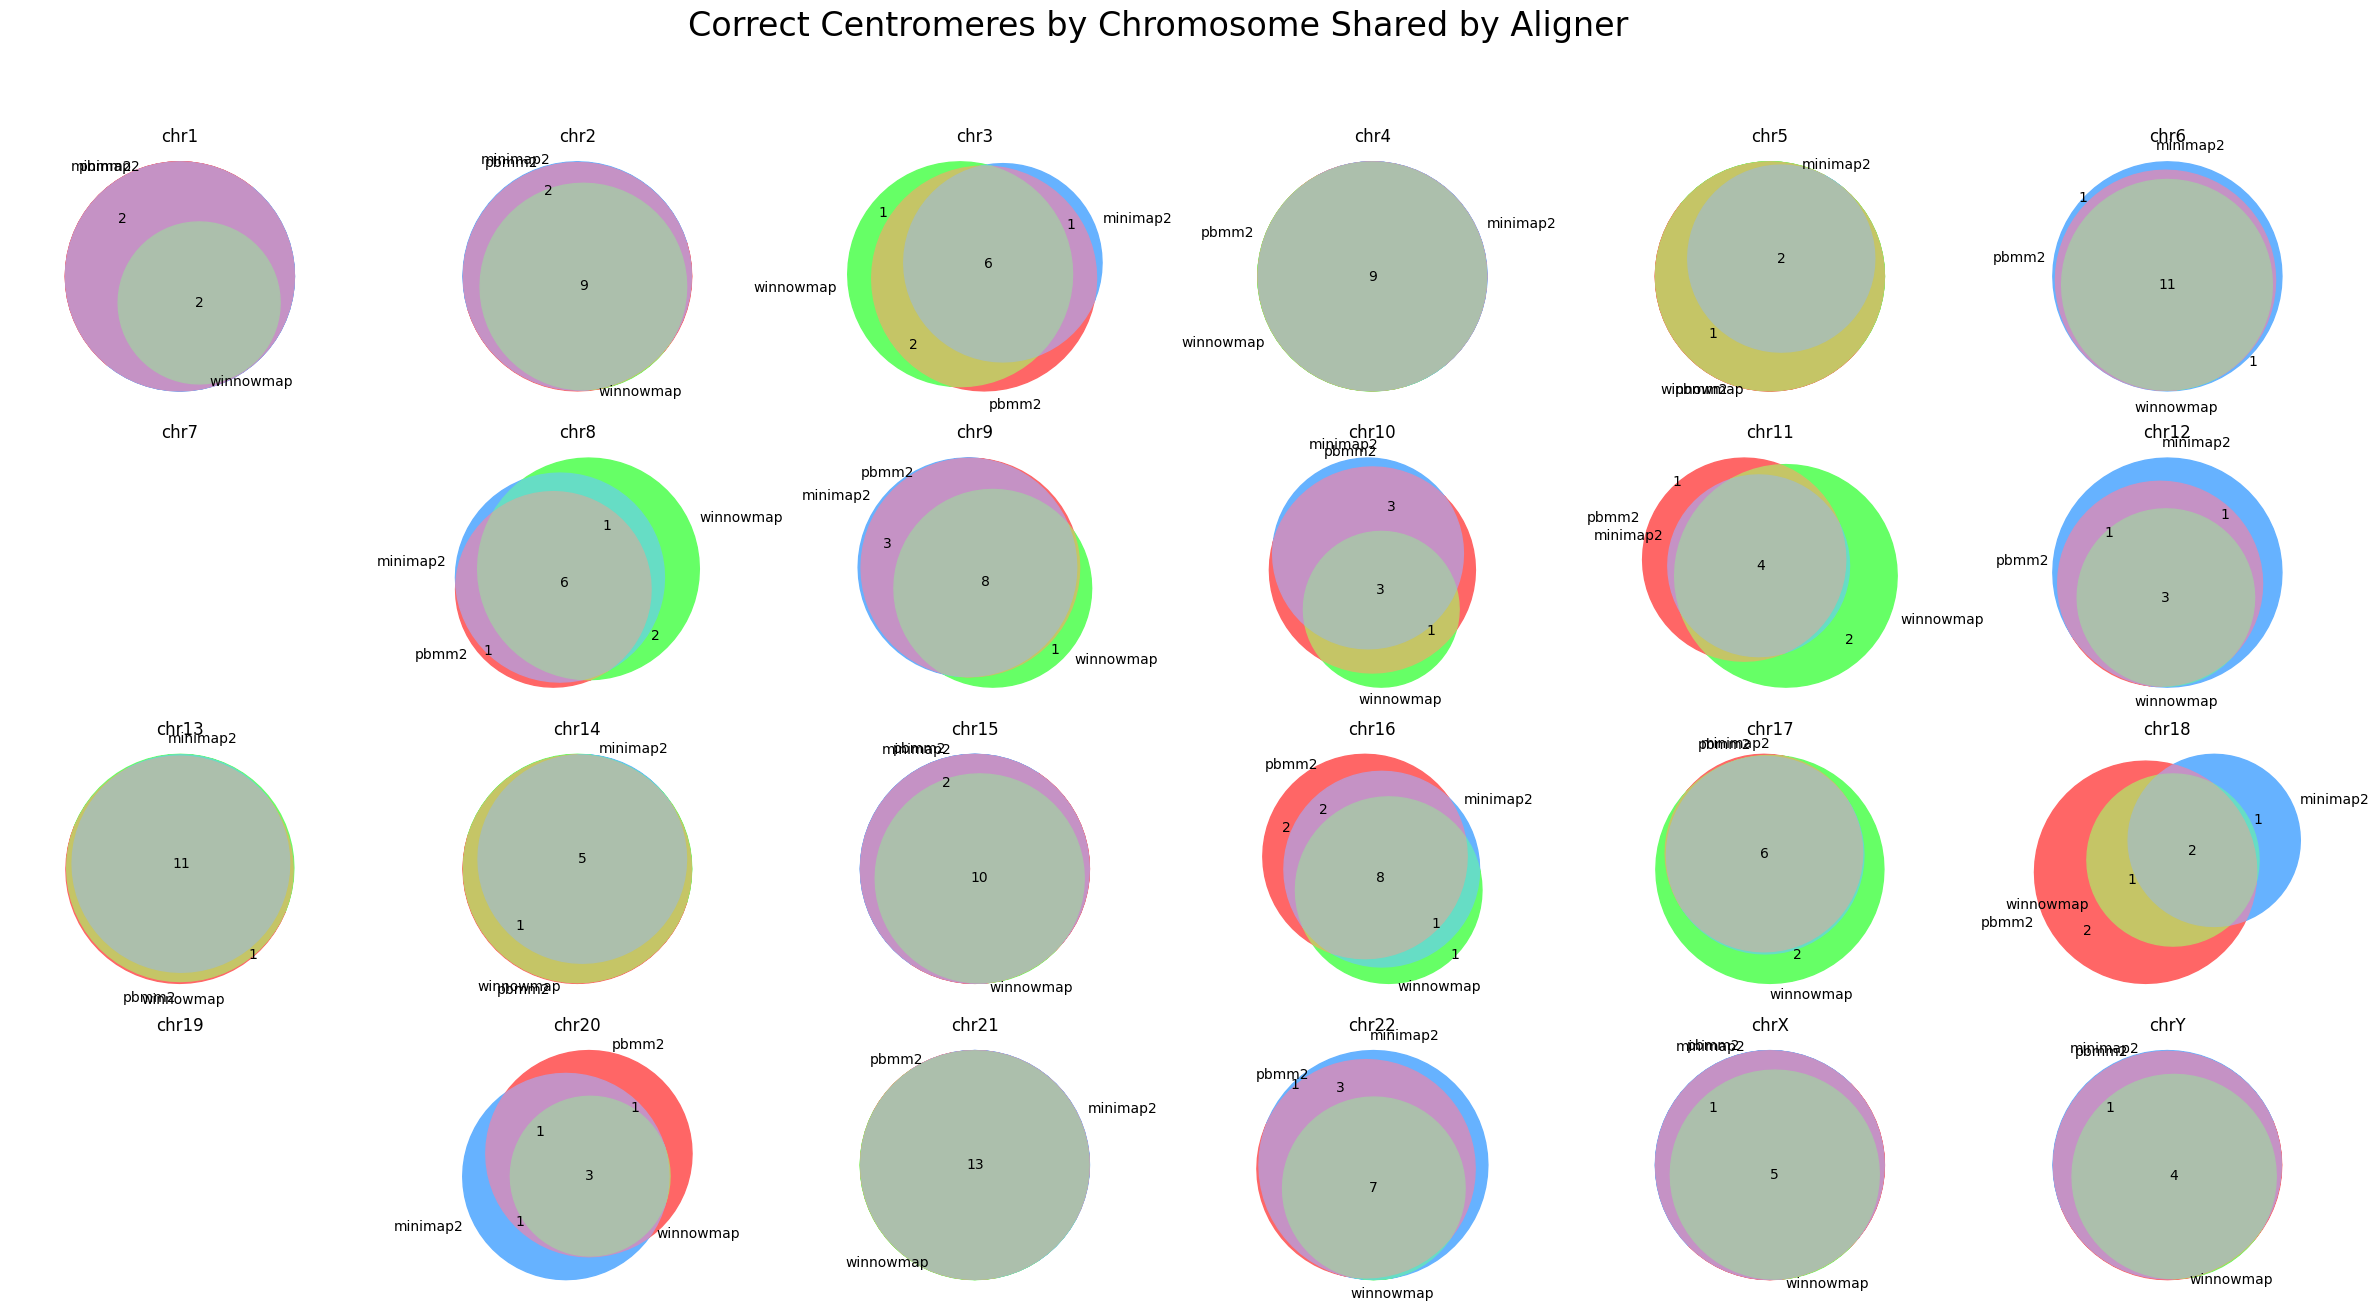

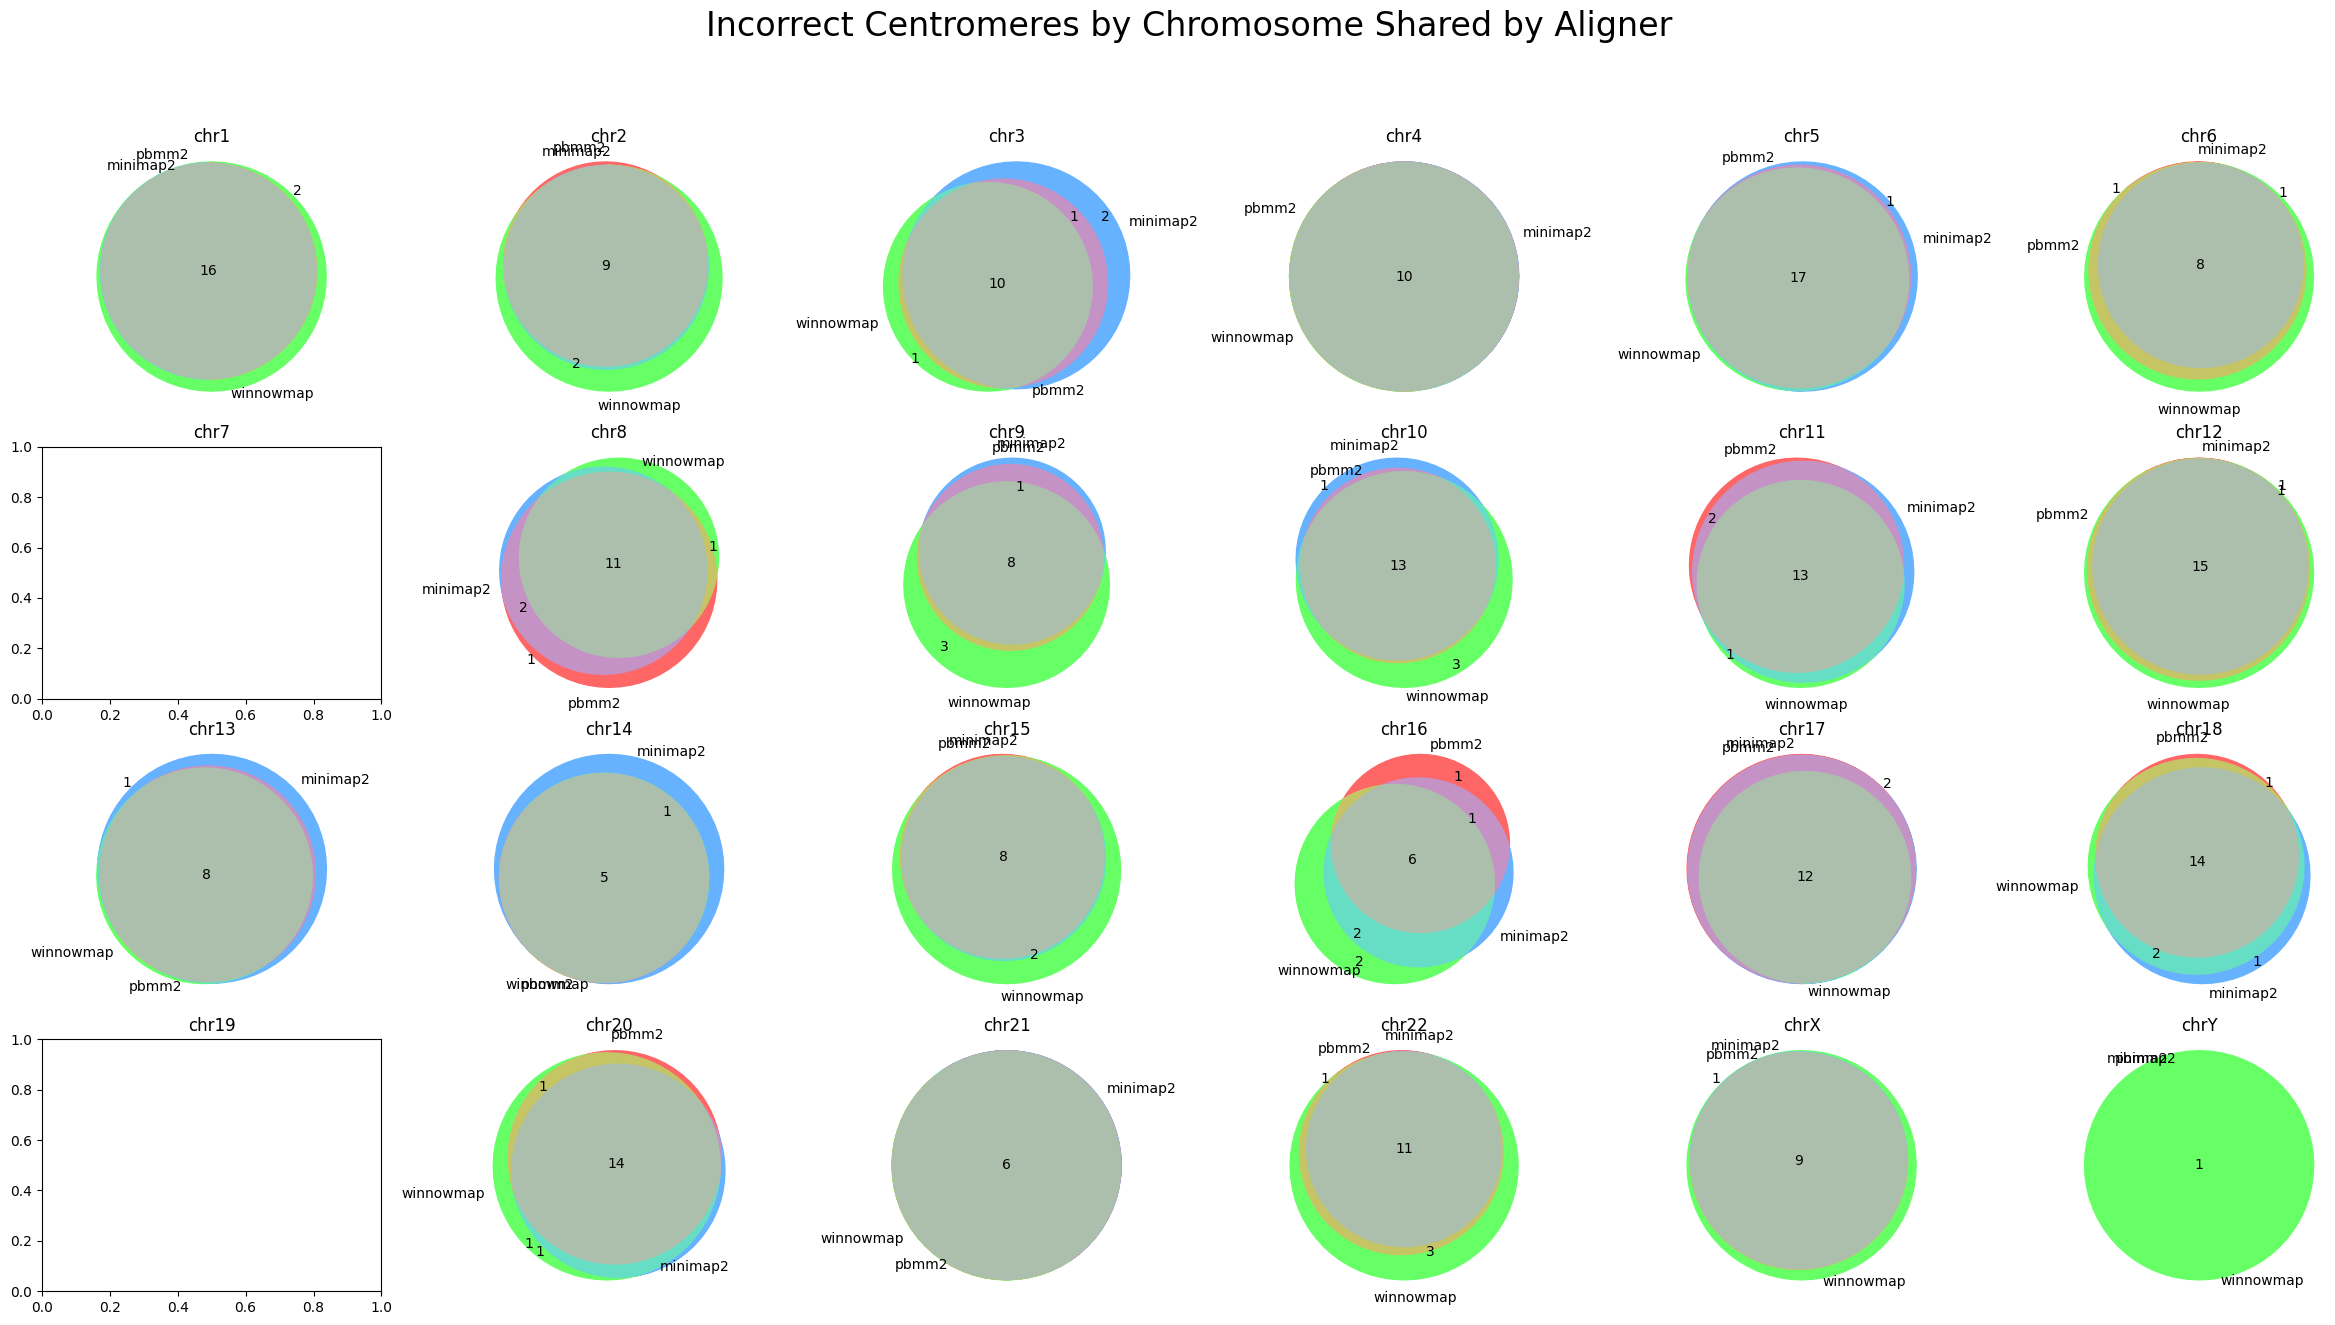

In [12]:
plt.close("all")
fig, axes = plt.subplots(
    nrows=4, ncols=6, figsize=(24, 12),
)
fig.tight_layout()
fig.suptitle("Correct Centromeres by Chromosome Shared by Aligner ", fontsize=24, y=1.10)

fig_incorrect, axes_incorrect = plt.subplots(
    nrows=4, ncols=6, figsize=(24, 12),
)
fig_incorrect.tight_layout()
fig_incorrect.suptitle("Incorrect Centromeres by Chromosome Shared by Aligner ", fontsize=24, y=1.10)

all_comb_cnts = defaultdict(int)
all_incorrect_comb_cnts = defaultdict(int)
for ax, incorrect_ax, (chrom_name, comb_cnt_list) in zip(flatten(axes), flatten(axes_incorrect), df_all_status_grouped_combined.iter_rows()):
    ax: plt.Axes
    incorrect_ax: plt.Axes
    comb_cnts = {}
    incorrect_comb_cnts = {}
    for comb in comb_cnt_list:
        comb_vals = comb.values()
        subset, size = comb_vals
        correct_subset = []
        incorrect_subset = []
        for i in subset:
            correct_subset.append(int(i))
            incorrect_subset.append(int(not int(i)))

        correct_subset = tuple(correct_subset)
        incorrect_subset = tuple(incorrect_subset)

        if correct_subset != (0, 0, 0):
            comb_cnts[correct_subset] = size
            all_comb_cnts[correct_subset] += size
        if incorrect_subset != (0, 0, 0):
            incorrect_comb_cnts[incorrect_subset] = size
            all_incorrect_comb_cnts[incorrect_subset] += size

    
    ax.set_title(chrom_name)
    incorrect_ax.set_title(chrom_name)

    if not comb_cnts:
        ax.axis("off")
        continue

    matplotlib_set_diagrams.EulerDiagram(
        comb_cnts,
        set_labels=ALIGNER_PARAMS.keys(),
        set_colors=ALIGNER_COLORS,
        cost_function_objective="squared",
        ax=ax
    )

    if not incorrect_comb_cnts:
        incorrect_ax.axis("off")
        continue

    matplotlib_set_diagrams.EulerDiagram(
        incorrect_comb_cnts,
        set_labels=ALIGNER_PARAMS.keys(),
        set_colors=ALIGNER_COLORS,
        cost_function_objective="squared",
        ax=incorrect_ax
    )

plt.savefig(OUTPUT_DIR.joinpath("venn_shared_correct_cens_by_chrom.png"))
plt.savefig(OUTPUT_DIR.joinpath("venn_shared_incorrect_cens_by_chrom.png"))

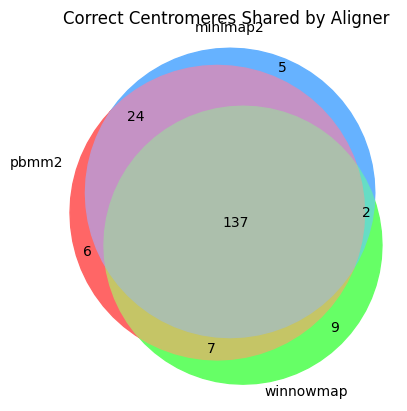

In [13]:
plt.close("all")
ax = plt.gca()
matplotlib_set_diagrams.EulerDiagram(
    all_comb_cnts,
    set_labels=ALIGNER_PARAMS.keys(),
    set_colors=ALIGNER_COLORS,
    cost_function_objective="squared",
    ax=ax
)
_ = ax.set_title("Correct Centromeres Shared by Aligner")
plt.savefig(OUTPUT_DIR.joinpath("venn_shared_correct_cens.png"))


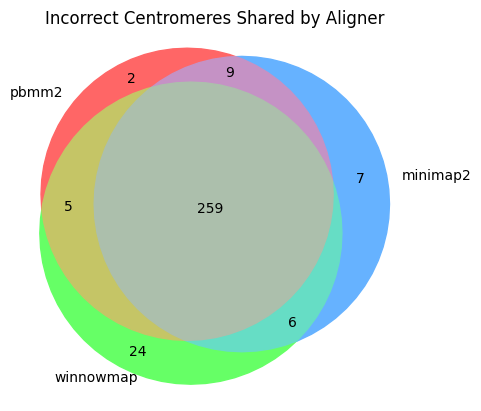

In [14]:
plt.close("all")
ax = plt.gca()
matplotlib_set_diagrams.EulerDiagram(
    all_incorrect_comb_cnts,
    set_labels=ALIGNER_PARAMS.keys(),
    set_colors=ALIGNER_COLORS,
    cost_function_objective="squared",
    ax=ax
)
_ = ax.set_title("Incorrect Centromeres Shared by Aligner")
plt.savefig(OUTPUT_DIR.joinpath("venn_shared_incorrect_cens.png"))

In [15]:
df_all_status_long_summarized_chr = (
    df_all_status_long.group_by("aligner", "chrom")
    .agg(pl.col("status").value_counts())
    .explode("status")
    .unnest("status")
    .sort("chrom", "aligner", "status")
)
df_all_status_long_summarized_chr

aligner,chrom,status,count
enum,enum,enum,u32
"""pbmm2""","""chr1""","""good""",4
"""pbmm2""","""chr1""","""misassembled""",16
"""winnowmap""","""chr1""","""good""",2
"""winnowmap""","""chr1""","""misassembled""",18
"""minimap2""","""chr1""","""good""",4
…,…,…,…
"""minimap2""","""chrX""","""misassembled""",9
"""pbmm2""","""chrY""","""good""",5
"""winnowmap""","""chrY""","""good""",4


In [16]:
df_all_status_long_summarized = df_all_status_long.group_by("aligner").agg(pl.col("status").value_counts()).explode("status").unnest("status")
df_all_status_long_summarized

aligner,status,count
enum,enum,u32
"""pbmm2""","""misassembled""",275
"""pbmm2""","""good""",174
"""winnowmap""","""good""",155
"""winnowmap""","""misassembled""",294
"""minimap2""","""misassembled""",281
"""minimap2""","""good""",168


In [17]:
df_def_counts = pl.DataFrame(
    zip(
        ALIGNER_PARAMS.keys(),
        [0 for _ in range(len(ALIGNER_PARAMS.keys()))]
    ),
    schema={"aligner": pl.Enum(ALIGNER_PARAMS.keys()), "def_count": pl.Int64}
)

In [18]:
status_legend_elements = [
    Patch(
        facecolor=color,
        label=status
    )
    for status, color in STATUS_COLORS.items()
]

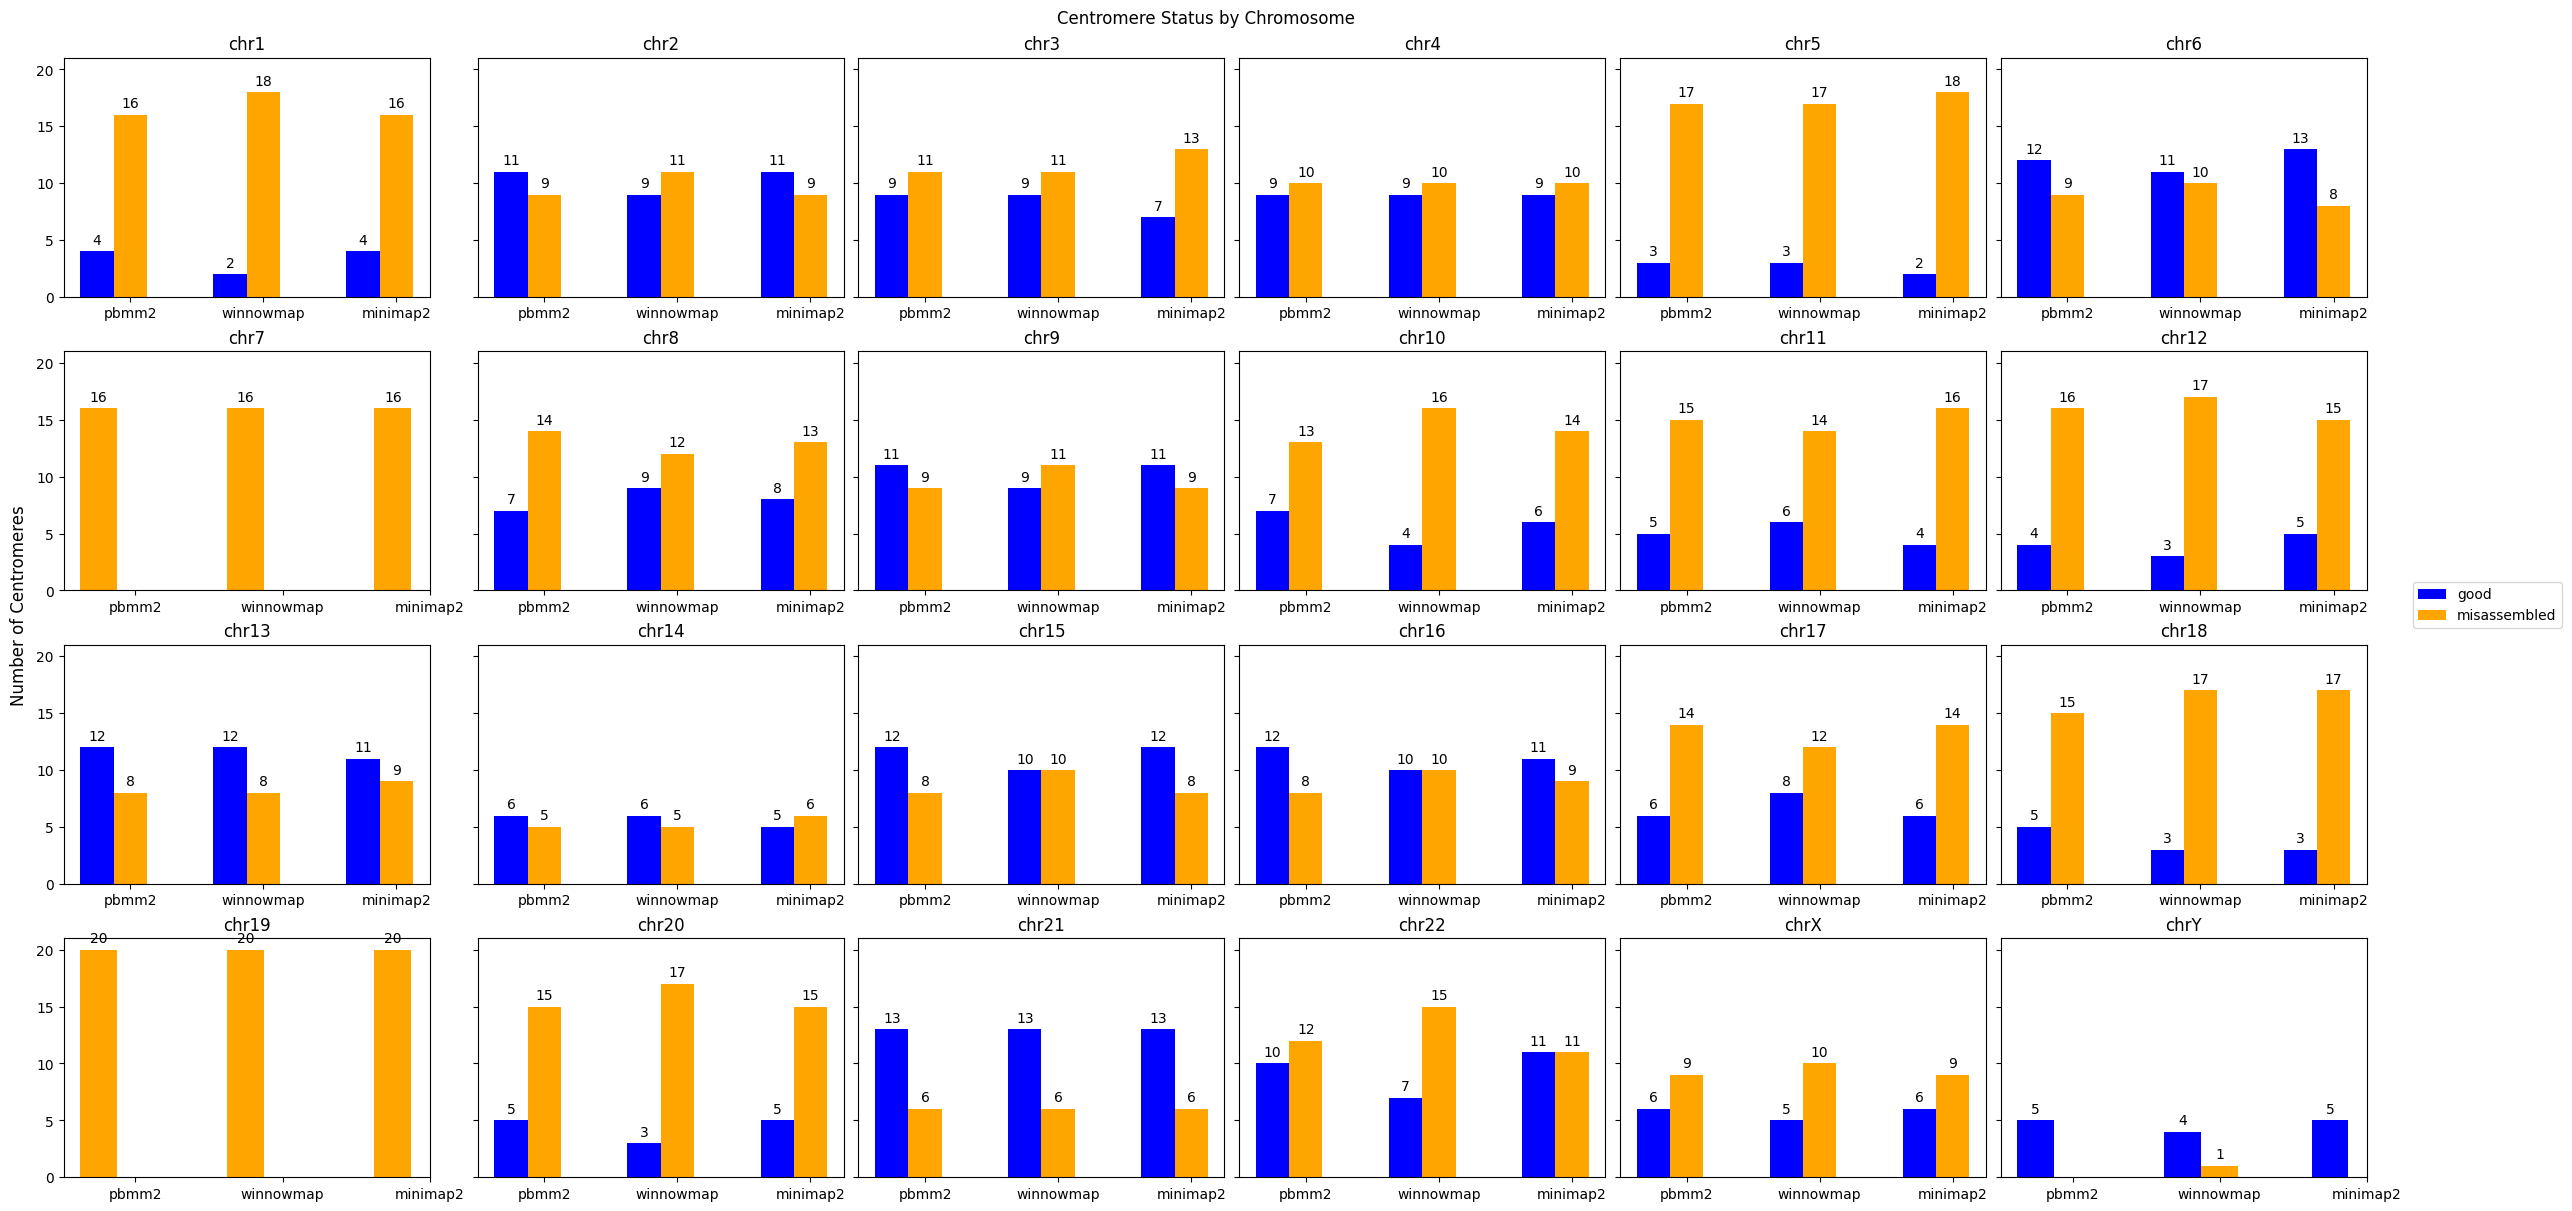

In [19]:
plt.close("all")
fig, axes = plt.subplots(4, 6, layout='constrained', figsize=(24, 12), sharey=True)
width = 0.25

for i, (chrom_name, df_chrom) in enumerate(df_all_status_long_summarized_chr.group_by(["chrom"], maintain_order=True)):
    row, col = divmod(i, 6)
    ax: plt.Axes = axes[row, col]
    chrom_name = chrom_name[0]
    x = np.arange(len(ALIGNER_PARAMS.keys()))
    for i2, (status, df_status_grp) in enumerate(df_chrom.group_by(["status"], maintain_order=True)):
        status = status[0]
        color = STATUS_COLORS[status]
        offset = width * i2
        df_status_grp = df_def_counts.join(df_status_grp, how="left", on="aligner", coalesce=True)
        rects = ax.bar(x + offset, df_status_grp["count"], width, label=status, color=color)
        ax.bar_label(rects, padding=3)
        ax.set_title(chrom_name)
        ax.set_xticks(x + width, ALIGNER_PARAMS.keys())

fig.supylabel("Number of Centromeres")
fig.suptitle('Centromere Status by Chromosome')
_ = fig.legend(handles=status_legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(OUTPUT_DIR.joinpath("cens_status_by_chrom.png"))

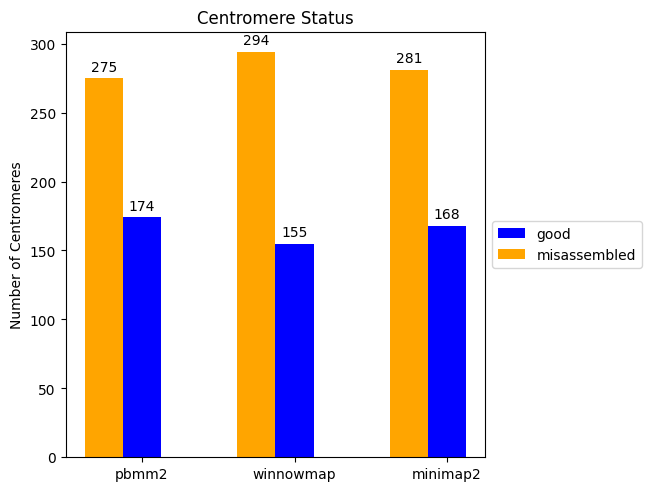

In [20]:
plt.close("all")
fig, ax = plt.subplots(layout='constrained')
ax: plt.Axes
width = 0.25

x = np.arange(len(ALIGNER_PARAMS.keys()))
for i, (status, df_status_grp) in enumerate(df_all_status_long_summarized.group_by(["status"], maintain_order=True)):
    status = status[0]
    color = STATUS_COLORS[status]
    offset = width * i
    rects = ax.bar(x + offset, df_status_grp["count"], width, label=status, color=color)
    ax.bar_label(rects, padding=3)

ax.set_ylabel('Number of Centromeres')
ax.set_title('Centromere Status')
ax.set_xticks(x + width, ALIGNER_PARAMS.keys())
_ = ax.legend(handles=status_legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
fig.savefig(OUTPUT_DIR.joinpath("cens_status.png"))